In [104]:
# importing all Dependencies

In [1]:
import tensorflow as tf 
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os

In [2]:
# Setting all constant

In [3]:
IMAGE_SIZE = 800
BATCH_SIZE = 10
CHANNELS=3
EPOCHS=10

In [4]:
# Importing data into tensorflow dataset object 

In [5]:
 dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "MedicinalPlants", 
     shuffle=True,
     image_size = (IMAGE_SIZE,IMAGE_SIZE),
     batch_size = BATCH_SIZE
 )

Found 444 files belonging to 13 classes.


In [6]:
class_names = dataset.class_names
class_names

['Arive-Dantu',
 'Basale',
 'Betel',
 'Curry',
 'Drumstick',
 'Fenugreek',
 'Hibiscus',
 'Jackfruit',
 'Jasmine',
 'Neem',
 'Peepal',
 'Roxburgh_fig',
 'Tulsi']

In [7]:
len(dataset)

45

In [8]:
10*45


450

In [9]:
# Batch wise images shown

In [10]:
 for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(10, 800, 800, 3)
[ 4  3  0  3  9 11  2  0  9  0]


In [11]:
# Visualizing data image from dataset

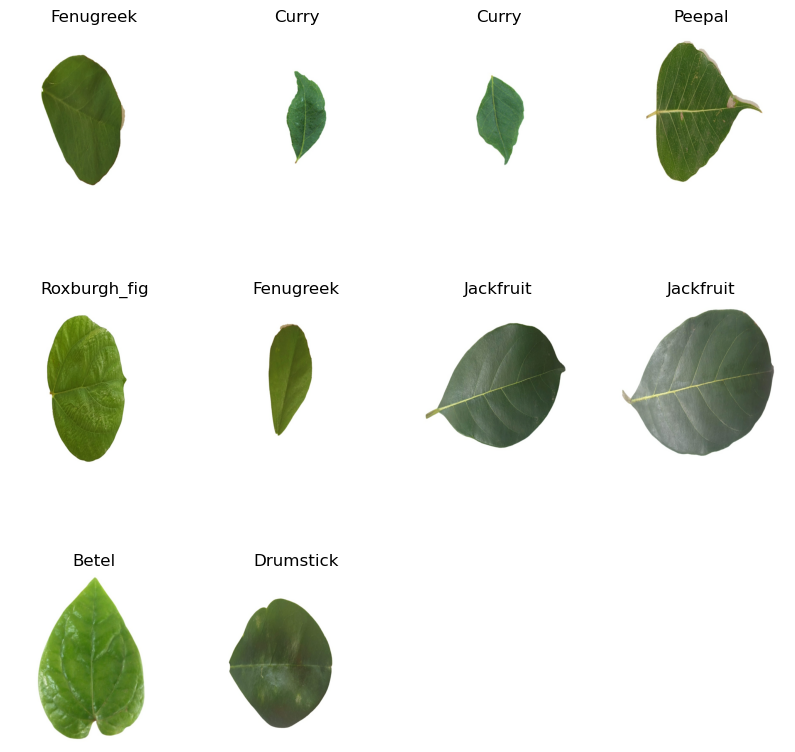

In [12]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
len(dataset)

45

In [14]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [15]:
train_size = 0.8
len(dataset)*train_size


36.0

In [16]:
train_ds = dataset.take(36)
len(train_ds)


36

In [17]:
test_ds = dataset.skip(36)
len(test_ds)

9

In [18]:
val_size=0.1
len(dataset)*val_size

4.5

In [19]:
val_ds = test_ds.take(4)
len(val_ds)

4

In [20]:
test_ds = test_ds.skip(4)
len(test_ds)

5

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

        train_size = int(train_split * ds_size)
        val_size = int(val_split * ds_size)
        
        train_ds = ds.take(train_size)
        
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).take(val_size)
        
        return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [23]:
len(train_ds)

36

In [24]:
len(val_ds)

4

In [25]:
len(test_ds)

4

In [26]:
# Cache, Shuffle and Prefetch the data

In [27]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
# Creating a layer for Resizing and Normalization 

In [29]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [30]:
# Data Augmentation : boost accuracy of data when have less data 

In [31]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [32]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
# Building CNN model through edge detection process 

In [34]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 13 

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(65, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (10, 800, 800, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 800, 800, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 798, 798, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 399, 399, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 397, 397, 65)      18785     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 198, 198, 65)     0         
 2D)                                                  

In [36]:
# Compiling the model

In [37]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)



In [38]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)  

Epoch 1/10
36/36 [==============================] - 315s 8s/step - loss: 2.5544 - accuracy: 0.1243 - val_loss: 2.4199 - val_accuracy: 0.2000
Epoch 2/10
36/36 [==============================] - 235s 7s/step - loss: 2.5268 - accuracy: 0.1554 - val_loss: 2.4235 - val_accuracy: 0.1500
Epoch 3/10
36/36 [==============================] - 228s 6s/step - loss: 2.4123 - accuracy: 0.1667 - val_loss: 2.4454 - val_accuracy: 0.1500
Epoch 4/10
36/36 [==============================] - 226s 6s/step - loss: 2.2102 - accuracy: 0.2655 - val_loss: 2.3615 - val_accuracy: 0.1750
Epoch 5/10
36/36 [==============================] - 226s 6s/step - loss: 1.9833 - accuracy: 0.3418 - val_loss: 2.2312 - val_accuracy: 0.2500
Epoch 6/10
36/36 [==============================] - 227s 6s/step - loss: 1.7594 - accuracy: 0.3785 - val_loss: 2.6358 - val_accuracy: 0.2500
Epoch 7/10
36/36 [==============================] - 228s 6s/step - loss: 1.5875 - accuracy: 0.4718 - val_loss: 1.9101 - val_accuracy: 0.3000
Epoch 8/10
36

In [40]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 4s 1s/step - loss: 2.3920 - accuracy: 0.4250


In [ ]:
# accurate result of the model

In [41]:
scores

[2.391993522644043, 0.42500001192092896]

In [42]:
history 



In [43]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 36}

In [44]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [45]:
history.history['loss'] # Shows loss of accuracy in each epoch 

[2.554361581802368,
 2.526818037033081,
 2.412313222885132,
 2.2101619243621826,
 1.9832617044448853,
 1.759402871131897,
 1.5874606370925903,
 1.354717493057251,
 1.1794930696487427,
 1.0873020887374878]

In [46]:
history.history['accuracy'] # shows accuracy of each epoch 

[0.12429378181695938,
 0.15536722540855408,
 0.1666666716337204,
 0.26553672552108765,
 0.34180790185928345,
 0.3785310685634613,
 0.4717514216899872,
 0.5451977252960205,
 0.598870038986206,
 0.6355932354927063]

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


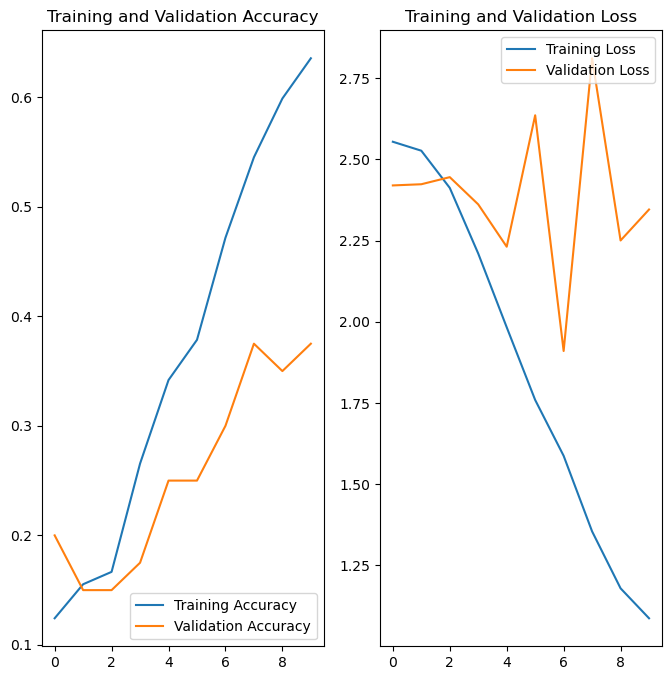

In [52]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: Drumstick
1/1 [==============================] - 1s 1s/step
predicted label: Hibiscus


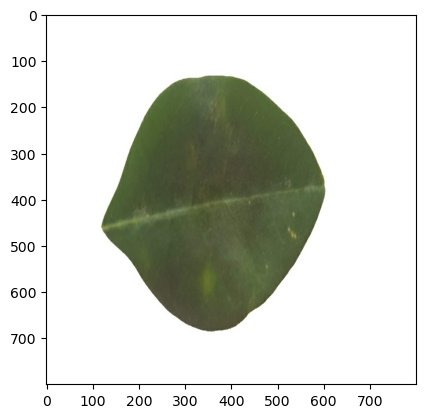

In [62]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

     
    

In [63]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 197ms/step


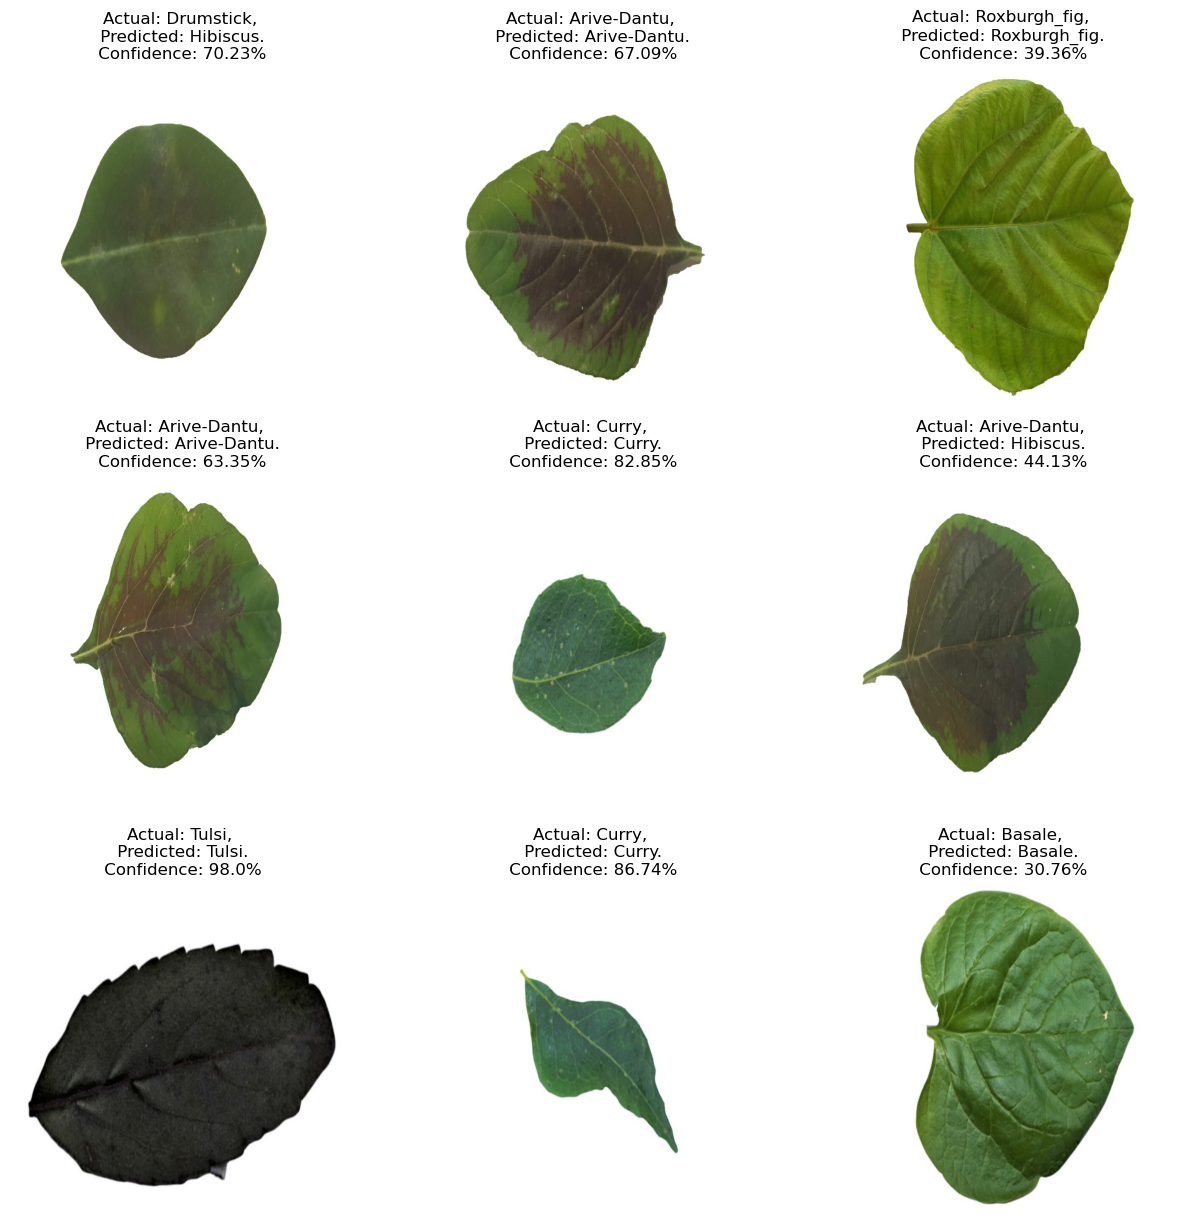

In [64]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
